# Sketching for low-rank nonnegative matrix approximation

## 0. Something

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

In [2]:
def svdr(a, r):
    u, s, vh = sp.linalg.svd(a)
    return u[:, :r], s[:r], vh[:r, :]

In [3]:
def TestMatrix(m, n, distribution='normal', p=None):
    if distribution == 'normal':
        res = np.random.normal(size=(m, n))
    elif distribution == 'rademacher' and p is None:
        res = np.random.choice([-1,1], size=(m,n))
    elif distribution == 'rademacher':
        res = np.random.choice([0,1,-1], size=(m,n), p=[1-p,p/2,p/2])
    else:
        raise TypeError('Invalid arguments')
    return res

In [4]:
def upd_info(X, alg_name, info): ## Distance to nonnegative matrices ##
    info[alg_name]['fro'].append(np.linalg.norm(X[X < 0]))
    neg_count = (X < 0).sum()
    info[alg_name]['density'].append(neg_count/(np.prod(X.shape)))
    if len(X[X < 0]) > 0:
        info[alg_name]['chebyshev'].append(max(abs(X[X < 0])))
    else:
        info[alg_name]['chebyshev'].append(0)

In [5]:
def get_alg_name(func, distribution, rho, p1, p2=None):
    d = 'N' if distribution=='normal' else 'Rad'
    if p2 is None:
        alg_name = f'{func.__name__}({p1}), {d}'
    else:
        alg_name = f'{func.__name__}({p1},{p2}), {d}'
    if d == 'N':
        alg_name += '(0,1)'
    elif rho is not None:
        alg_name += f'({rho})'
    return alg_name

## 1. Algorithms

### 1.1 SVD (exact alternating projections)

In [6]:
def SVD(X, r, s=100, info=None):
    if info:
        alg_name = 'SVD'
        info[alg_name] = {'chebyshev': [], 'fro': [], 'density': []}
    Ur, Sr, Vhr = svdr(X, r)
    Yi = Ur * Sr @ Vhr
    for i in range(s):
        Yi[Yi < 0] = 0
        Ur, Sr, Vhr = svdr(Yi, r)
        Yi = Ur * Sr @ Vhr
        if info:
            upd_info(Yi, alg_name, info)
    if info:
        for norm in info[alg_name]:
            info[alg_name][norm] = np.asarray(info[alg_name][norm])
    return Ur, Sr, Vhr

### 1.2 Tangent (alternating projections via tangent spaces)

In [7]:
def Tangent(X, r, s=100, info=None):
    if info:
        alg_name = 'Tangent'
        info[alg_name] = {'chebyshev': [], 'fro': [], 'density': []}
    Ur, Sr, Vhr = svdr(X, r)
    Yi = Ur * Sr @ Vhr
    Ur, Sr, Vhr = svdr(Yi, r)
    for i in range(s):
        Yi[Yi < 0] = 0
        I = np.eye(Ur.shape[0], Ur.shape[0])
        P = Ur@Ur.T@Yi + (I - Ur@Ur.T)@Yi@Vhr.T@Vhr
        Ur, Sr, Vhr = svdr(P, r)
        Yi = Ur * Sr @ Vhr
        if info:
            upd_info(Yi, alg_name, info)
    if info:
        for norm in info[alg_name]:
            info[alg_name][norm] = np.asarray(info[alg_name][norm])
    return Ur, Sr, Vhr

### 1.3 HMT

In [8]:
def HMT(X, r, p, k, distribution='normal', rho=None, s=100, info=None):
    if info:
        alg_name = get_alg_name(HMT, distribution, rho, p, k)
        info[alg_name] = {'chebyshev': [], 'fro': [], 'density': []}
    m, n = X.shape
    Ur, Sr, Vhr = svdr(X, r)
    Yi = Ur * Sr @ Vhr
    for i in range(s):
        Yi[Yi < 0] = 0
        Psi = TestMatrix(n, k, distribution, rho)
        Z1 = Yi @ Psi
        Q, R = np.linalg.qr(Z1)
        for j in range(p):
            Z2 = Q.T @ Yi
            Q, R = np.linalg.qr(Z2.T)
            Z1 = Yi @ Q
            Q, R = np.linalg.qr(Z1)
        Z2 = Q.T @ Yi
        Ur, Sr, Vhr = svdr(Z2, r)
        Ur = Q @ Ur
        Yi = Ur * Sr @ Vhr
        if info:
            upd_info(Yi, alg_name, info)
    if info:
        for norm in info[alg_name]:
            info[alg_name][norm] = np.asarray(info[alg_name][norm])
    return Ur, Sr, Vhr

### 1.4 Tropp

In [9]:
def Tropp(X, r, k, l, distribution='normal', rho=None, s=100, info=None):
    if info:
        alg_name = get_alg_name(Tropp, distribution, rho, k, l)
        info[alg_name] = {'chebyshev': [], 'fro': [], 'density': []}
    m, n = X.shape
    Ur, Sr, Vhr = svdr(X, r)
    Yi = Ur * Sr @ Vhr
    for i in range(s):
        Yi[Yi < 0] = 0
        Psi = TestMatrix(n, k, distribution, rho)
        Phi = TestMatrix(l, m, distribution, rho)
        Z = Yi @ Psi
        Q, R = np.linalg.qr(Z)
        W = Phi @ Q
        P, T = np.linalg.qr(W)
        G = np.linalg.inv(T) @ P.T @ Phi @ Yi
        Ur, Sr, Vhr = svdr(G, r)
        Ur = Q @ Ur
        Yi = Ur * Sr @ Vhr
        if info:
            upd_info(Yi, alg_name, info)
    if info:
        for norm in info[alg_name]:
            info[alg_name][norm] = np.asarray(info[alg_name][norm])
    return Ur, Sr, Vhr

### 1.5 GN (generalized Nystrom method)

In [10]:
def GN(X, r, l, distribution='normal', rho=None, s=100, info=None):
    if info:
        alg_name = get_alg_name(GN, distribution, rho, l)
        info[alg_name] = {'chebyshev': [], 'fro': [], 'density': []}
    m, n = X.shape
    Yi = X.copy()
    for i in range(s):
        Yi[Yi < 0] = 0
        Psi = TestMatrix(n, r, distribution, rho)
        Phi = TestMatrix(l, m, distribution, rho)
        Z = Yi @ Psi
        W = Phi @ Z
        Q, R = np.linalg.qr(W)
        V = (Phi@Yi).T @ Q
        U = Z @ np.linalg.inv(R)
        Yi = U @ V.T
        if info:
            upd_info(Yi, alg_name, info)
    if info:
        for norm in info[alg_name]:
            info[alg_name][norm] = np.asarray(info[alg_name][norm])
    return U, V.T

### 1.6  HOSVD-based algorithm for nonnegative tensor approximation

In [11]:
def unfold(a, k):
    shape = a.shape
    size = np.prod(shape)
    lsize = size // shape[k]
    sizelist = list(range(len(shape)))
    sizelist[k] = 0
    sizelist[0] = k
    return a.transpose(sizelist).reshape(shape[k],lsize)

In [12]:
def mode_k_product(a, b, k):
    if a.shape[k] != b.shape[0]:
        raise RuntimeError(f'a.shape[{k}] != b.shape[0]')
    c_shape = list(a.shape)
    c_shape[k] = b.shape[1]
    c = np.zeros(c_shape)
    m, n, l = c.shape
    for i in range(m):
        for j in range(n):
            for t in range(l):
                index = [i,j,t]
                i0 = index[k]
                for p in range(a.shape[k]):
                    index[k] = p
                    i1, i2, i3 = index
                    c[i,j,t] += a[i1,i2,i3] * b[p,i0]
    return c

In [13]:
def restore_tensor(s, u_list):
    res = mode_k_product(s, u_list[0].T, 0)
    for k, u in enumerate(u_list[1:], 1):
        res = mode_k_product(res, u.T, k=k)
    return res

In [14]:
def HOSVD(a, r, alg_func, info=None, **kwargs):
    if info is not None:
        info.clear()
    U_list = []
    S = a
    for k, nk in enumerate(a.shape):
        if info is not None:
            info.append({'HOSVD':None})
            kwargs['info'] = info[-1]
        ak = unfold(a, k)
        if alg_func.__name__ == 'GN':
            u, _ = alg_func(ak, r[k], **kwargs)
        else:
            u, _, _ = alg_func(ak, r[k], **kwargs)
        U_list.append(u)
        S = mode_k_product(S, u, k=k)
    return S, U_list

## 2. Numerical experiments

### 2.1 Random uniform matrices

In [15]:
m = 256
n = 256
r = 64

In [16]:
a = np.random.rand(m, n)
u, s, vh = svdr(a, r)
ar = u*s@vh
_, s, _ = np.linalg.svd(a)
s /= s[0]

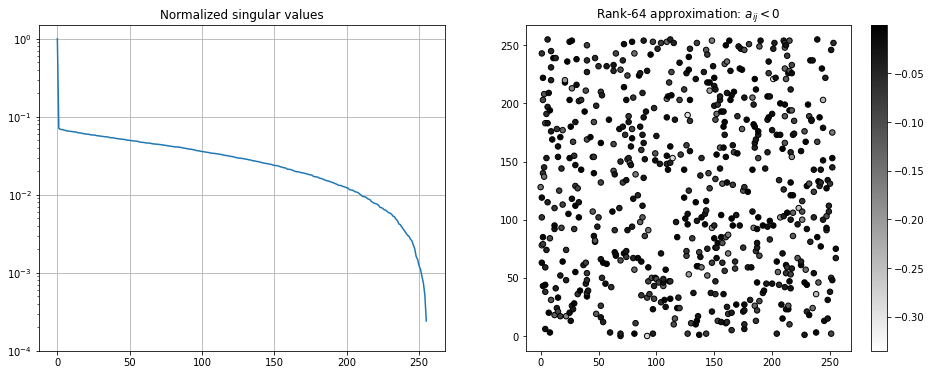

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].set_title(r'Normalized singular values')
ax[0].plot(range(len(s)), s)
ax[0].set_yscale('log')
ax[0].set_yticks([10**(-x) for x in range(-int(np.log10(s[-1]))+2)])
ax[0].grid()

plt.set_cmap('gray_r')
ax[1].set_title(r'Rank-%d approximation: $a_{ij} < 0$' % r)
sc = ax[1].scatter(*np.where(ar < 0), s=30, c=ar[np.where(ar < 0)], edgecolors='black')
_ = plt.colorbar(sc)

In [18]:
trials = 10

mean_info = {}
for i in range(trials):
    a = np.random.rand(m, n)
    info = {'SVD':None}
    SVD(a, r, info=info)
    Tangent(a, r, info=info)
    HMT(a, r, p=1, k=70, distribution='normal', info=info)
    HMT(a, r, p=0, k=70, distribution='rademacher', rho=0.2, info=info)
    Tropp(a, r, k=70, l=100, distribution='rademacher', rho=0.2, info=info)
    Tropp(a, r, k=70, l=85, distribution='rademacher', rho=0.2, info=info)
    GN(a, r, l=150, distribution='rademacher', rho=0.2, info=info)
    GN(a, r, l=120, distribution='rademacher', rho=0.2, info=info)
    if not i:
        mean_info = info=info
    else:
        for alg_name in info:
            for norm in info[alg_name]:
                mean_info[alg_name][norm] += info[alg_name][norm]

for alg_name in mean_info:
    for norm in mean_info[alg_name]:
        mean_info[alg_name][norm] /= trials

In [19]:
labels    = ['Chebyshev', 'Frobenius', 'Density']
colors    = ['C0', 'C1', 'C2']
yticks    = [10**(-x) for x in range(-1, 16, 2)]
title     = 'Distance to nonnegative matrices' 
alg_names = np.asarray([['SVD', 'Tangent'],\
                        ['HMT(1,70), N(0,1)', 'HMT(0,70), Rad(0.2)'],\
                        ['Tropp(70,100), Rad(0.2)', 'Tropp(70,85), Rad(0.2)'],\
                        ['GN(150), Rad(0.2)', 'GN(120), Rad(0.2)']])

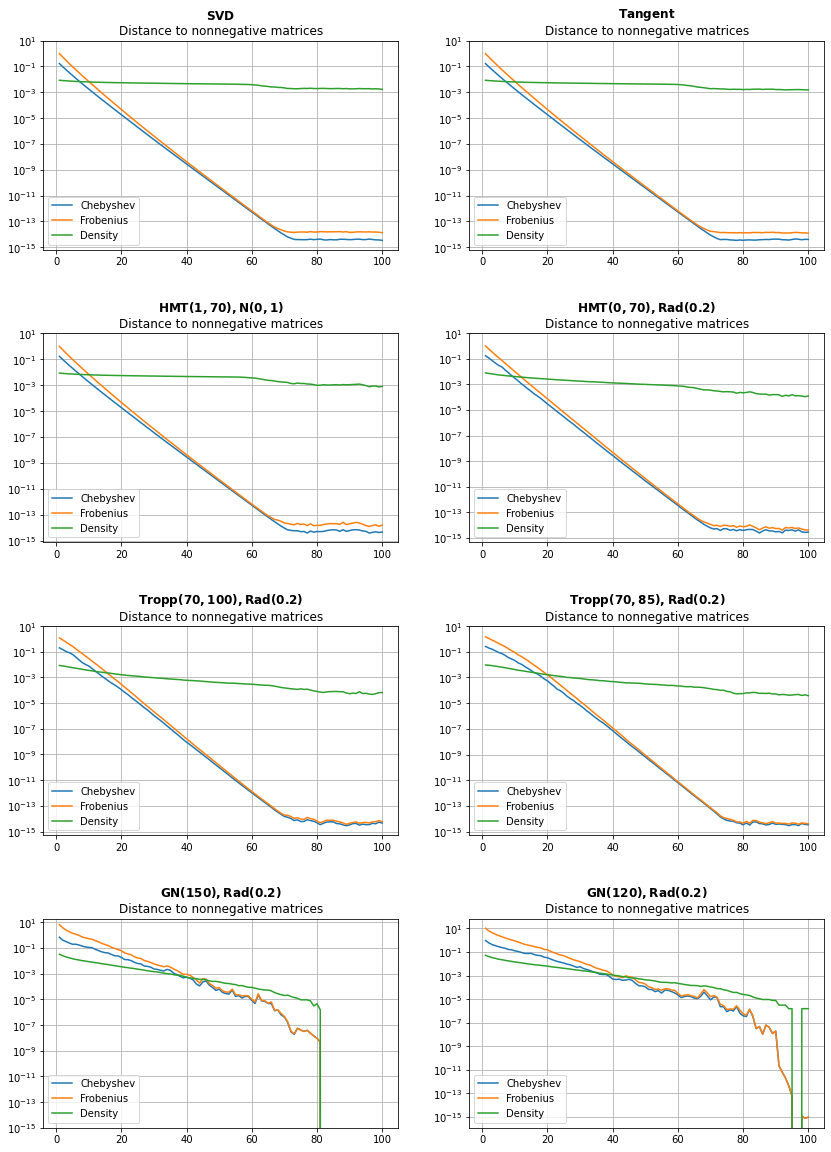

In [20]:
fig, ax = plt.subplots(4, 2, figsize=(14, 20))

for i in range(4):
    for j in range(2):
        alg_name = alg_names[i,j]
        ax[i,j].plot(range(1, 101), mean_info[alg_name]['chebyshev'], colors[0], label=labels[0])
        ax[i,j].plot(range(1, 101), mean_info[alg_name]['fro'],       colors[1], label=labels[1])
        ax[i,j].plot(range(1, 101), mean_info[alg_name]['density'],   colors[2], label=labels[2])
        ax[i, j].set_title('$\\bf{%s}$\n%s' % (alg_name, title))
        ax[i, j].grid()
        ax[i, j].set_yscale('log')
        ax[i, j].set_yticks(yticks)
        ax[i, j].legend(loc='lower left')

plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.show()

### 2.2 B/W image

In [21]:
img = mpimg.imread('img.jpg')
img = img.mean(axis=2)

ur, sr, vhr = svdr(img, 50)
_, s, _ = np.linalg.svd(img)
s = s/s[0]
img_r = ur * sr @ vhr

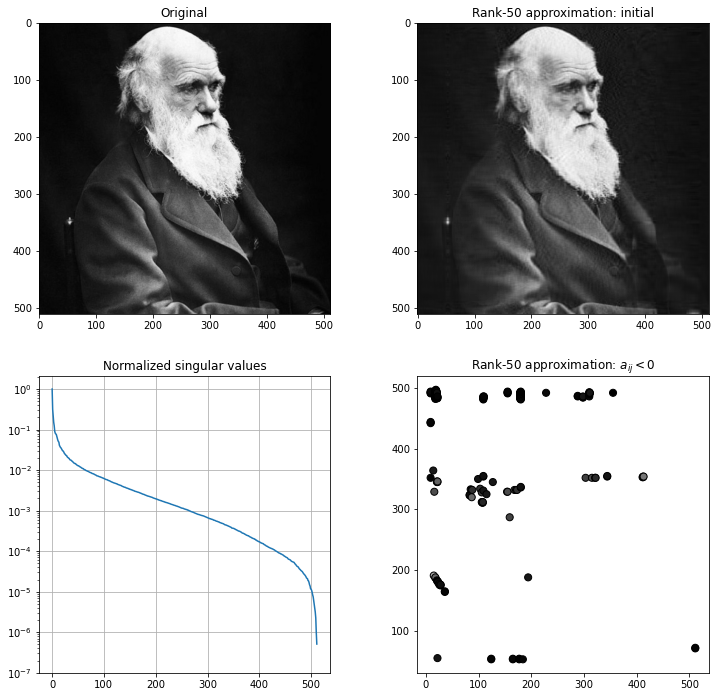

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0,0].set_title('Original')
ax[0,0].imshow(img, cmap='gray')

ax[0,1].set_title('Rank-50 approximation: initial')
ax[0,1].imshow(img_r, cmap='gray')

ax[1,0].set_title(r'Normalized singular values')
ax[1,0].plot(range(len(s)), s)
ax[1,0].set_yscale('log')
ax[1,0].set_yticks([10**(-x) for x in range(-int(np.log10(s[-1]))+2)])
ax[1,0].grid()

plt.set_cmap('gray_r')
ax[1,1].set_title(r'Rank-50 approximation: $a_{ij} < 0$')
ax[1,1].scatter(*np.where(img_r < 0), s=50, c=img_r[np.where(img_r < 0)], edgecolors='black')

plt.subplots_adjust(wspace=0.3)

In [23]:
r = 50
info = {'SVD':None}

u, s, vh     = SVD(img, r, s=300, info=info)
img_svd_     = u * s @ vh
u, s, vh     = Tangent(img, r, s=300, info=info) 
img_tangent_ = u * s @ vh
u, s, vh     = HMT(img, r, p=0, k=60, distribution='rademacher', rho=0.2, s=300, info=info) 
img_hmt_     = u * s @ vh
u, s, vh     = Tropp(img, r, k=60, l=120, distribution='rademacher', rho=0.2, s=300, info=info) 
img_tropp_   = u * s @ vh
u, vh        = GN(img, r, l=340, distribution='rademacher', rho=0.2, s=300, info=info) 
img_gn_      = u @ vh

In [24]:
print('----------------------------')
print('HMT')
print('----------------------------')
print('neg. elements    | %.2f %s' % ((img_hmt_ < 0).sum() / (img_hmt_ > 0).sum() * 100, '%'))
print('nonzero elements | %.2f %s' % ((img_hmt_ != 0).sum() / np.prod(img_hmt_.shape) * 100, '%'))
print('min/max          | %d/%d'   % (img_hmt_.min(), img_hmt_.max()))
print('relative error   | %.2f'    % (np.linalg.norm(img-img_hmt_) / np.linalg.norm(img)))
print('----------------------------')
print('Tropp')
print('----------------------------')
print('neg. elements    | %.2f %s' % ((img_tropp_ < 0).sum() / (img_tropp_ > 0).sum() * 100, '%'))
print('nonzero elements | %.2f %s' % ((img_tropp_ != 0).sum() / np.prod(img_tropp_.shape) * 100, '%'))
print('min/max          | %d/%d'   % (img_tropp_.min(), img_tropp_.max()))
print('relative error   | %.2f'    % (np.linalg.norm(img-img_tropp_) / np.linalg.norm(img)))
print('----------------------------')
print('GN')
print('----------------------------')
print('neg. elements    | %.2f %s' % ((img_gn_ < 0).sum() / (img_gn_ > 0).sum() * 100, '%'))
print('nonzero elements | %.2f %s' % ((img_gn_ != 0).sum() / np.prod(img_gn_.shape) * 100, '%'))
print('min/max:         | %d/%d'   % (img_gn_.min(), img_gn_.max()))
print('relative error   | %.2f'    % (np.linalg.norm(img-img_gn_) / np.linalg.norm(img)))
print('----------------------------')

----------------------------
HMT
----------------------------
neg. elements    | 0.00 %
nonzero elements | 100.00 %
min/max          | 0/268
relative error   | 0.07
----------------------------
Tropp
----------------------------
neg. elements    | 0.00 %
nonzero elements | 100.00 %
min/max          | 0/268
relative error   | 0.07
----------------------------
GN
----------------------------
neg. elements    | 0.00 %
nonzero elements | 100.00 %
min/max:         | 0/299
relative error   | 0.13
----------------------------


In [25]:
labels    = ['Chebyshev', 'Frobenius', 'Density']
colors    = ['C0', 'C1', 'C2']
yticks    = [10**(-x) for x in range(-1, 16, 2)]
title     = 'Distance to nonnegative matrices'
alg_names = ['SVD', 'Tangent', 'HMT(0,60), Rad(0.2)', 'Tropp(60,120), Rad(0.2)', 'GN(340), Rad(0.2)']
imgs      = [img_svd_, img_tangent_, img_hmt_, img_tropp_, img_gn_]

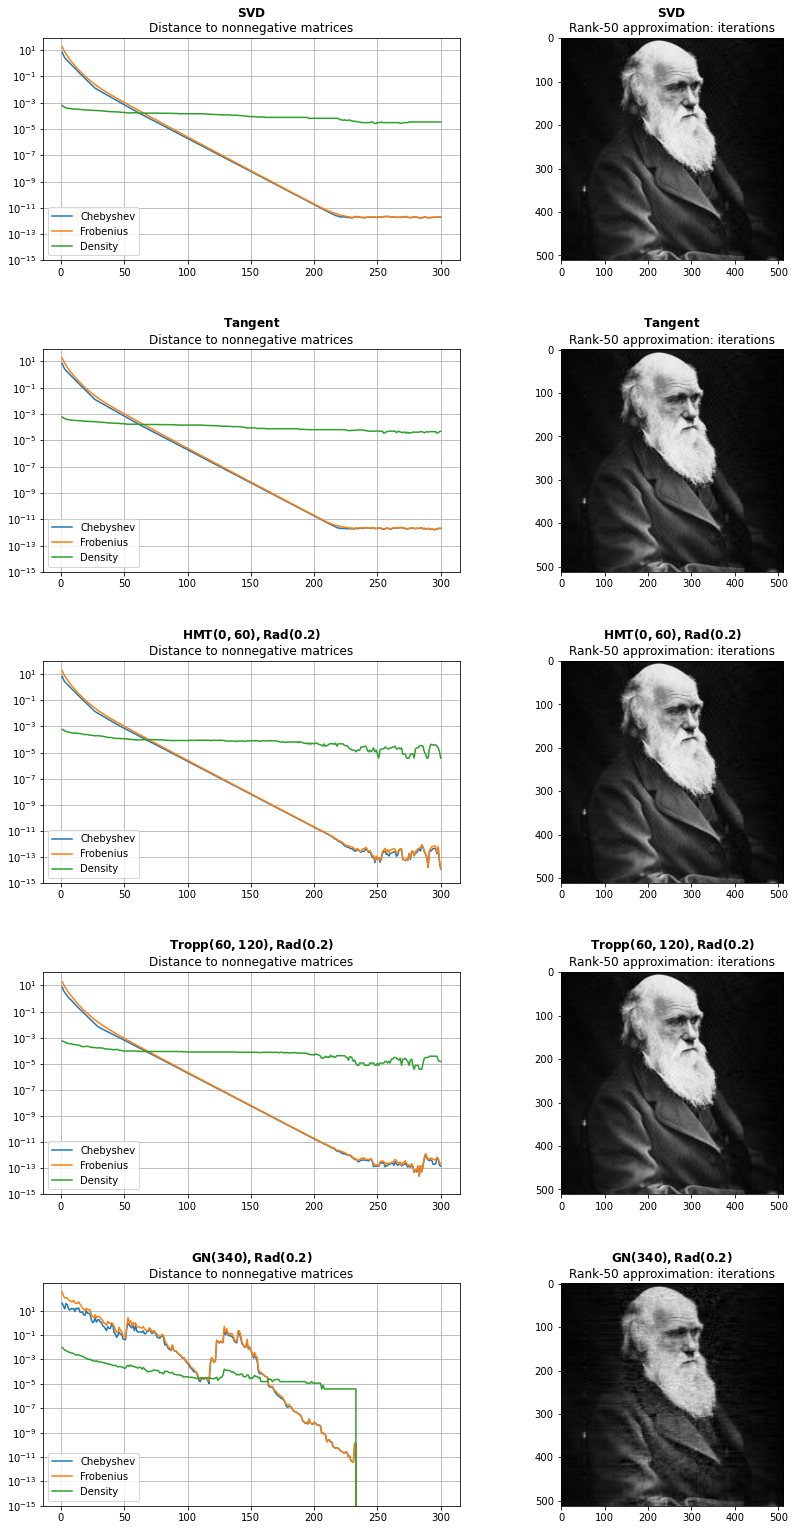

In [26]:
fig, ax = plt.subplots(5, 2, figsize=(15, 27))

for i in range(5):
    alg_name = alg_names[i]
    ax[i,0].plot(range(1, 301), info[alg_name]['chebyshev'], colors[0], label=labels[0])
    ax[i,0].plot(range(1, 301), info[alg_name]['fro'],       colors[1], label=labels[1])
    ax[i,0].plot(range(1, 301), info[alg_name]['density'],   colors[2], label=labels[2])
    ax[i,0].set_yscale('log')
    ax[i,0].set_yticks(yticks)
    ax[i,0].set_title('$\\bf{%s}$\n%s' % (alg_name, title))
    ax[i,0].legend(loc='lower left')
    ax[i,0].grid()
    
    ax[i,1].set_title('$\\bf{%s}$\n%s' % (alg_name, 'Rank-50 approximation: iterations'))
    ax[i,1].imshow(imgs[i], cmap='gray')

plt.subplots_adjust(wspace=0.01, hspace=0.4)

### 2.3. Color image

In [27]:
img = mpimg.imread('img3D.jpg')
r = [50, 50, 3]

In [28]:
info_hmt = []
start = time.time()
S_hmt, Ulist_hmt = HOSVD(img, r, HMT, info=info_hmt, p=0, k=70, distribution='rademacher', rho=0.2)
end = time.time()
print('%d min %d s' % ((end-start)/60, (end-start)%60))

10 min 45 s


In [29]:
info_tropp = []
start = time.time()
S_tropp, Ulist_tropp = HOSVD(img, r, Tropp, info=info_tropp, k=60, l=90, distribution='rademacher', rho=0.2)
end = time.time()
print('%d min %d s' % ((end-start)/60, (end-start)%60))

10 min 0 s


In [30]:
info_gn = []
start = time.time()
S_gn, Ulist_gn = HOSVD(img, r, GN, info=info_gn, l=160, distribution='rademacher', rho=0.2)
end = time.time()
print('%d min %d s' % ((end-start)/60, (end-start)%60))

0 min 15 s


In [31]:
img_hmt = restore_tensor(S_hmt, Ulist_hmt)
img_hmt = img_hmt.astype(int)

img_tropp = restore_tensor(S_tropp, Ulist_tropp)
img_tropp = img_tropp.astype(int)

img_gn = restore_tensor(S_gn, Ulist_gn)
img_gn = img_gn.astype(int)

In [32]:
print('----------------------------')
print('HMT')
print('----------------------------')
print('neg. elements    | %.2f %s' % ((img_hmt < 0).sum() / (img_hmt > 0).sum() * 100, '%'))
print('nonzero elements | %.2f %s' % ((img_hmt != 0).sum() / np.prod(img_hmt.shape) * 100, '%'))
print('min/max          | %d/%d'   % (img_hmt.min(), img_hmt.max()))
print('relative error   | %.2f'    % (np.linalg.norm(img-img_hmt) / np.linalg.norm(img)))
print('----------------------------')
print('Tropp')
print('----------------------------')
print('neg. elements    | %.2f %s' % ((img_tropp < 0).sum() / (img_tropp > 0).sum() * 100, '%'))
print('nonzero elements | %.2f %s' % ((img_tropp != 0).sum() / np.prod(img_tropp.shape) * 100, '%'))
print('min/max          | %d/%d'   % (img_tropp.min(), img_tropp.max()))
print('relative error   | %.2f'    % (np.linalg.norm(img-img_tropp) / np.linalg.norm(img)))
print('----------------------------')
print('GN')
print('----------------------------')
print('neg. elements    | %.2f %s' % ((img_gn < 0).sum() / (img_gn > 0).sum() * 100, '%'))
print('nonzero elements | %.2f %s' % ((img_gn != 0).sum() / np.prod(img_gn.shape) * 100, '%'))
print('min/max:         | %d/%d'   % (img_gn.min(), img_gn.max()))
print('relative error   | %.2f'    % (np.linalg.norm(img-img_gn) / np.linalg.norm(img)))
print('----------------------------')

----------------------------
HMT
----------------------------
neg. elements    | 1.18 %
nonzero elements | 99.62 %
min/max          | -26/295
relative error   | 0.10
----------------------------
Tropp
----------------------------
neg. elements    | 1.16 %
nonzero elements | 99.61 %
min/max          | -27/292
relative error   | 0.10
----------------------------
GN
----------------------------
neg. elements    | nan %
nonzero elements | 0.00 %
min/max:         | 0/0
relative error   | 1.00
----------------------------


/tmp/ipykernel_187/2105621300.py:18: RuntimeWarning: invalid value encountered in long_scalars
  print('neg. elements    | %.2f %s' % ((img_gn < 0).sum() / (img_gn > 0).sum() * 100, '%'))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


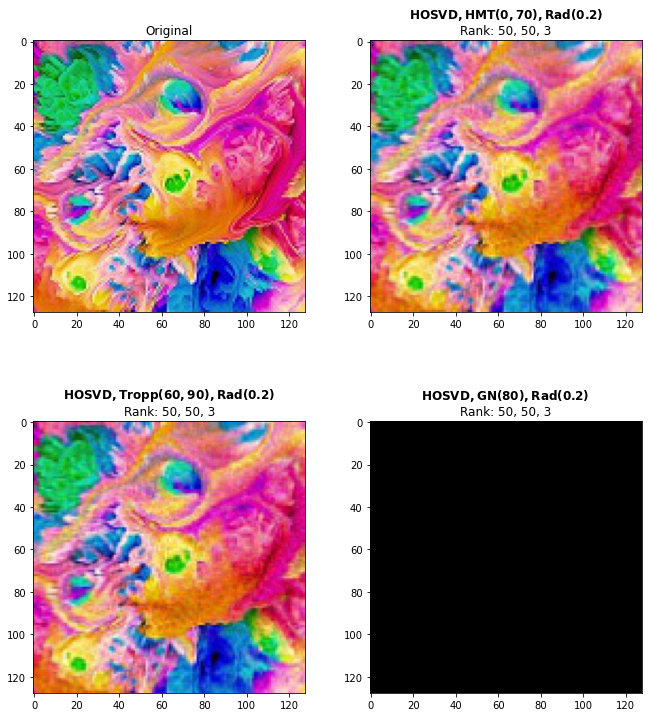

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0,0].set_title('Original')
ax[0,0].imshow(img)

ax[0,1].set_title('$\\bf{HOSVD, %s}$\nRank: %d, %d, %d' % (get_alg_name(HMT,'rademacher',0.2,0,70), r[0],r[1],r[2]))
ax[0,1].imshow(img_hmt)

ax[1,0].set_title('$\\bf{HOSVD, %s}$\nRank: %d, %d, %d' % (get_alg_name(Tropp,'rademacher',0.2,60,90), r[0],r[1],r[2]))
ax[1,0].imshow(img_tropp)

ax[1,1].set_title('$\\bf{HOSVD, %s}$\nRank: %d, %d, %d' % (get_alg_name(GN,'rademacher',0.2,80), r[0],r[1],r[2]))
ax[1,1].imshow(img_gn)

plt.subplots_adjust(wspace=0.01, hspace=0.4)

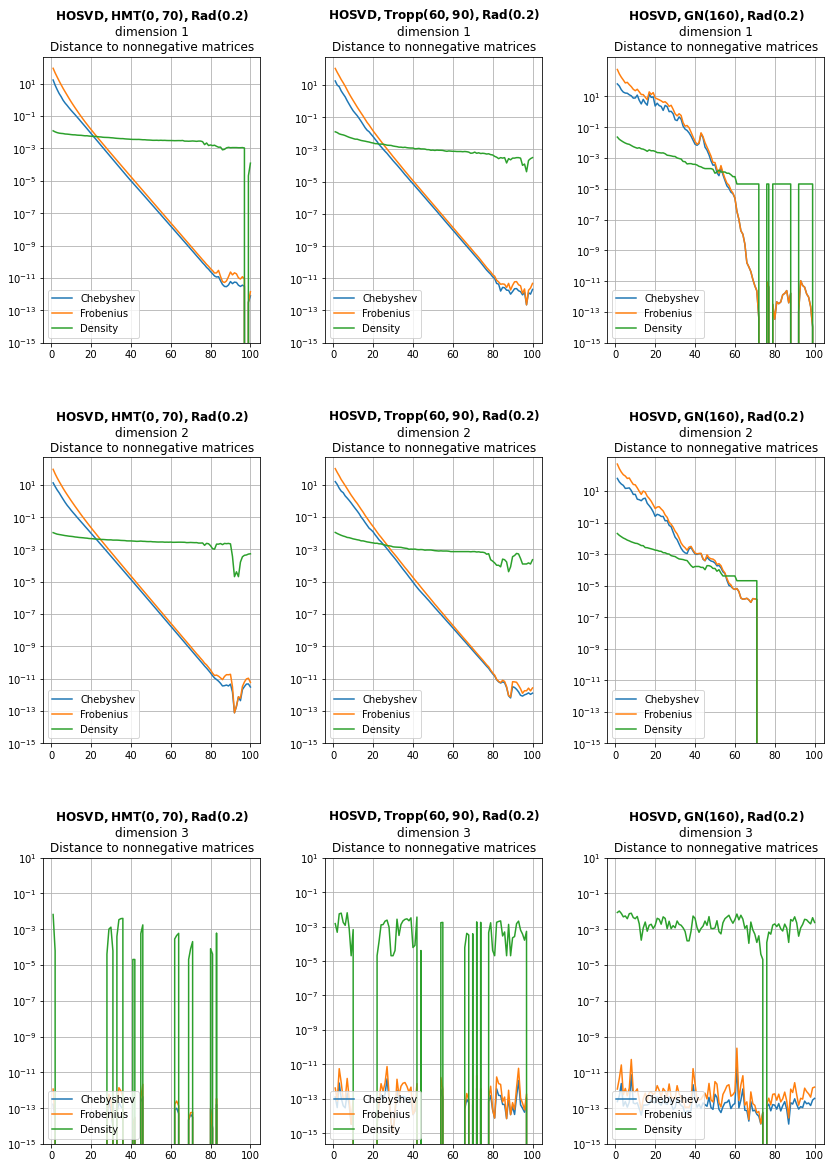

In [34]:
title = 'Distance to nonnegative matrices'
alg0_name = get_alg_name(HMT,'rademacher',0.2,0,70)
alg1_name = get_alg_name(Tropp,'rademacher',0.2,60,90)
alg2_name = get_alg_name(GN,'rademacher',0.2,160)
inf  = [info_hmt, info_tropp, info_gn]
algs = [alg0_name, alg1_name, alg2_name]

fig, ax = plt.subplots(3, 3, figsize=(14, 20))

for i in range(3):
    for j in range(3):
        alg_name = algs[j]
        ax[i,j].plot(range(1, 101), inf[j][i][alg_name]['chebyshev'], colors[0], label=labels[0])
        ax[i,j].plot(range(1, 101), inf[j][i][alg_name]['fro'],       colors[1], label=labels[1])
        ax[i,j].plot(range(1, 101), inf[j][i][alg_name]['density'],   colors[2], label=labels[2])
    
        ax[i,j].set_title('$\\bf{HOSVD, %s}$\ndimension %d\n%s' % (alg_name, i+1, title))
        ax[i,j].grid()
        ax[i,j].set_yscale('log')
        ax[i,j].set_yticks(yticks)
        ax[i,j].legend(loc='lower left')

plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()